# Getting Started: 
This is an example script to demonstrate the capabilities of UQregressors with some examples that you can copy and paste to start generating results in a matter of minutes. If you are considering whether to use this package and do not need a detailed implementation and explanation yet, please check the QuickStart examples page. 

There are five main capabilities of UQRegessors: 

1. **Dataset** loading and validation 
2. **Regression** using models of various types created with UQ capability
3. **Hyperparameter Tuning** using bayesian optimization (wrapper around Optuna)
4. **Metrics** for evaluating goodness of fit and quality of uncertainty intervals
5. **Visualization** of metrics, goodness of fit, and quality of uncertainty intervals

This script demonstrates basic usage of each of these five features by creating a data set from realizations of a 1-dimensional sine wave generator with some small added noise, the magnitude of which varies with the input coordinate. 

### Dataset Generation / Validation
As an example for this notebook, we will draw samples from a sine function with small added noise that scales with x.
$$ 
y=\sin(2 \pi x) + 0.1 \epsilon x, \epsilon \sim \mathcal{N}(0,1)
$$

A dataset is considered to be a sequence of input values (`x`) of shape (n_samples, n_features), and a one dimensional target (`y`), which is contained in a 2D array of shape (n_samples, 1). 

We introduce the methods `clean_dataset` and `validate_dataset` to deal with missing values and to verify that the inputs and targets are shaped correctly and have the same number of samples. `validate_dataset` should be called each time a new dataset is loaded. If `validate_dataset` fails, we can call `clean_dataset` before in order to coerce `x` and `y` into the right form. Additionally, we generate a test set of data samples to evaluate on. 

In [1]:
import numpy as np
import torch 
from uqregressors.utils.data_loader import clean_dataset, validate_dataset
import matplotlib.pyplot as plt
import seaborn as sns # For visualization
plt.rcParams['font.size'] = 20

# Set Random Seed for Reproducibility
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

# Define a data generator function to generate targets from features
def true_function(x, beta=0.1):
    noise = beta * x * np.random.standard_normal((len(x), 1))
    return np.sin(2 * np.pi * x) + noise

n_test = 250 
n_train = 150

X_test = np.linspace(0, 1, n_test).reshape(-1, 1)
y_test = true_function(X_test)
y_noiseless = true_function(X_test, beta=0)

X_train = np.sort(rng.rand(n_train, 1))
y_train = true_function(X_train).ravel() 

# clean_dataset drops missing or NaN values and reshapes X and y to 2D np arrays
X_train, y_train = clean_dataset(X_train, y_train)

# Confirm the shapes of X and y, and that there are no missing or NaN values
validate_dataset(X_train, y_train, name="Synthetic Sine")

Summary for: Synthetic Sine dataset
Number of samples: 150
Number of features: 1
Output shape: (150, 1)
Dataset validation passed.



We also define a plotting function that can be used to visualize regressor results: 

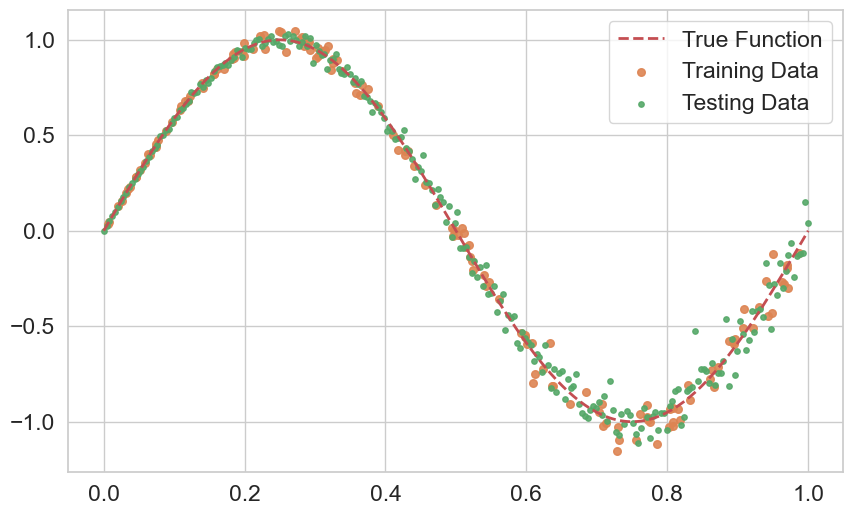

In [2]:

sns.set(style="whitegrid", font_scale=1.5)
colors = sns.color_palette("deep")
# Seaborn colors
color_true = colors[3]    # blue
color_train = colors[1]   # orange
color_test = colors[2]    # green
color_mean = colors[0]    # red
color_interval = colors[0]  # purple or teal depending on palette

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_noiseless, color=color_true, linestyle='--', linewidth=2, label="True Function")
plt.scatter(X_train, y_train, color=color_train, alpha=0.9, s=30, label="Training Data")
plt.scatter(X_test, y_test, color=color_test, alpha=0.9, s=15, label="Testing Data")
plt.legend()
plt.show()

def plot_uncertainty_results(mean, lower, upper, model_name): 
    plt.figure(figsize=(10, 6))

    # Plot true function
    plt.plot(X_test, y_noiseless, color=color_true, linestyle='--', linewidth=2, label="True Function")

    # Training and testing data
    plt.scatter(X_train, y_train, color=color_train, alpha=0.9, s=30, label="Training Data")
    plt.scatter(X_test, y_test, color=color_test, alpha=0.9, s=15, label="Testing Data")

    # Predicted mean and uncertainty
    plt.plot(X_test, mean, color=color_mean, linewidth=2, label="Predicted Mean")
    plt.fill_between(X_test.ravel(), lower, upper, color=color_interval, alpha=0.4, label="Uncertainty Interval")

    # Plot settings
    plt.title(f"{model_name} Uncertainty Test")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

## Regressors

Regressors are models which predict `y` from `x`. Regressors follow the scikit-learn API, where they are first initialized with all relevant settings, then optimized to fit the training data with the `fit(X, y)` function. New predictions are made with the `predict(X)` method, which will return the Tuple `(mean, lower, upper)`, where each of these elements is a one dimensional array containing the mean prediction, the predicted lower bound, and the predicted upper bound. Confidence is controlled with the `alpha` parameter, where the confidence level is 1 - `alpha`. For example, to construct 95% confidence intervals, set `alpha=0.05`. 

Each regressor also has a `save` and `load` method, which stores the regressor parameters, along with any metrics, training, and testing data to disk. These functions are explored in detail in other example files. Each type of regressor currently implemented is fit to the sine function above, and visualized. 

These examples solely describe the implementation and some key parameters of the regressor types. A detailed description of each regressor type is available in the Regressor Details section of the documentation. 

### MC Dropout


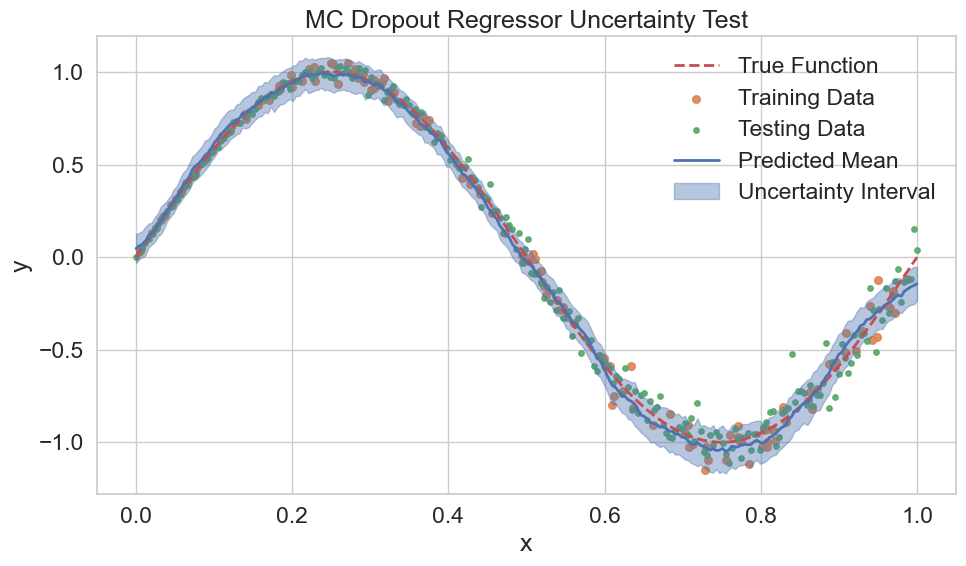

In [ ]:
from uqregressors.bayesian.dropout import MCDropoutRegressor
from uqregressors.utils.logging import set_logging_config

set_logging_config(print=False) # Disable logging for all future regressors for cleanliness

dropout = MCDropoutRegressor(
    hidden_sizes=[100, 100],
    dropout=0.1, # Dropout probability before each layer
    alpha=0.1,  # 90% confidence
    tau=1e6, # Aleatoric Uncertainty; should be tuned to provide accurate intervals
    n_samples=100, # Number of forward passes during predictions
    scale_data=True, # Internally standardizes the data before training and prediction
    epochs=1000,
    learning_rate=1e-3,
    device="cpu",  # use "cuda" if GPU available
    use_wandb=False # Weights and biases logging as an experimental feature
)

# sklearn fit and predict API
dropout.fit(X_train, y_train)
dropout_sol = dropout.predict(X_test) # dropout_sol = (mean_prediction, lower_bound, upper_bound)

plot_uncertainty_results(*dropout_sol, "MC Dropout Regressor")

### Deep Ensemble

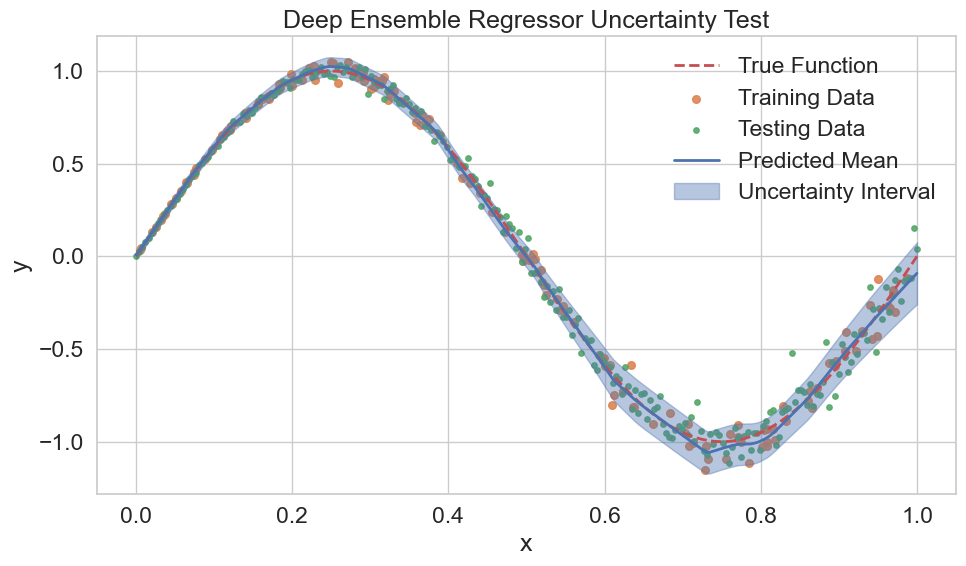

In [ ]:
from uqregressors.bayesian.deep_ens import DeepEnsembleRegressor

deep_ens = DeepEnsembleRegressor(
    n_estimators=5, # Number of estimators to use within the ensemble
    hidden_sizes=[100, 100],
    alpha=0.1,
    scale_data=True,
    epochs=1000,
    learning_rate=1e-3,
    device="cpu", 
    n_jobs=1, # Experimental: Number of parallel jobs using joblib
    use_wandb=False)

deep_ens.fit(X_train, y_train)
deep_ens_sol = deep_ens.predict(X_test)

plot_uncertainty_results(*deep_ens_sol, "Deep Ensemble Regressor")

### Standard Gaussian Process Regression (GPR)

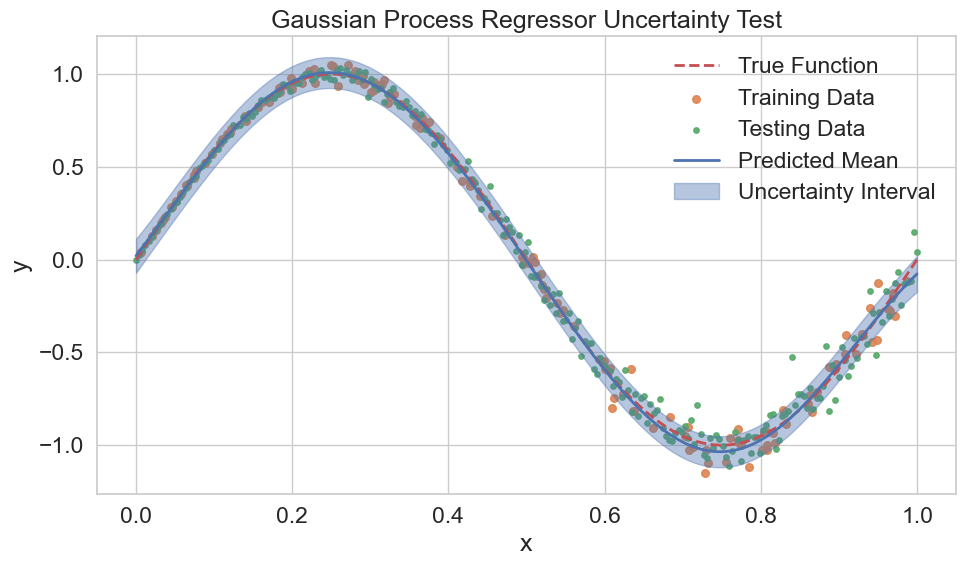

In [ ]:
from uqregressors.bayesian.gaussian_process import GPRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

gp_kwargs = {"normalize_y": True}
gpr = GPRegressor(
    kernel= RBF(length_scale=0.2, length_scale_bounds=(0.05, 1)) + WhiteKernel(noise_level=1), # Kernel function supported by sklearn
    alpha=0.1, 
    gp_kwargs=gp_kwargs # keyword arguments to sklearn's GPRegressor
    )

gpr.fit(X_train, y_train)
gp_sol = gpr.predict(X_test)
plot_uncertainty_results(*gp_sol, "Gaussian Process Regressor")

### BBMM Gaussian Process

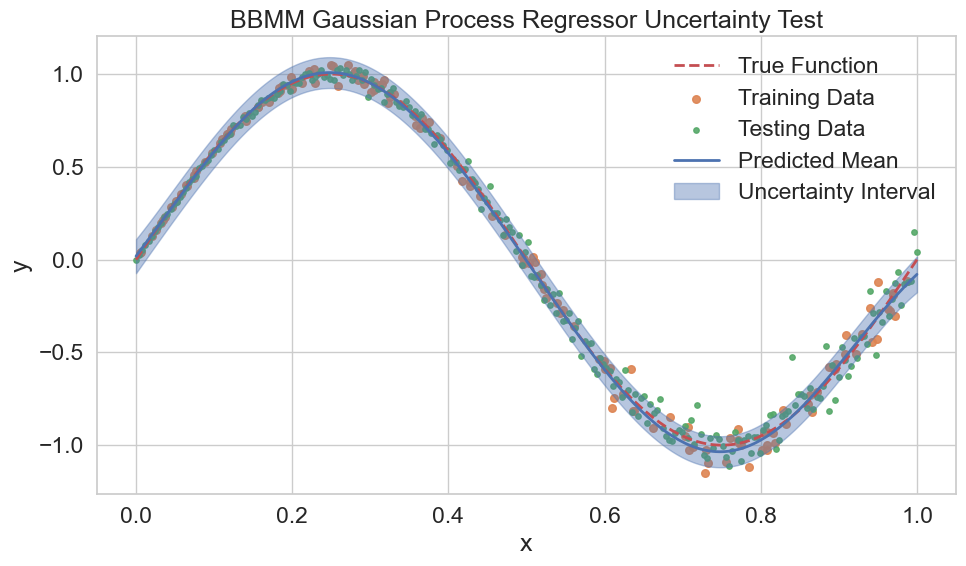

In [ ]:
from uqregressors.bayesian.bbmm_gp import BBMM_GP
import gpytorch

bbmm_gp = BBMM_GP(kernel=gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), # gpytorch kernel
                           likelihood=gpytorch.likelihoods.GaussianLikelihood(), # gpytorch likelihood
                           alpha = 0.1,
                           epochs=1000,
                           learning_rate=1e-1,
                           device="cpu",
                           use_wandb=False)

bbmm_gp.fit(X_train, y_train)
bbmm_gp_sol = bbmm_gp.predict(X_test)
plot_uncertainty_results(*bbmm_gp_sol, "BBMM Gaussian Process Regressor")

### Split Conformal Quantile Regression

In [ ]:
from uqregressors.conformal.cqr import ConformalQuantileRegressor 

cqr = ConformalQuantileRegressor(hidden_sizes = [100, 100], 
                                 cal_size=0.2, # Proportion of training data to use for conformal calibration
                                 alpha=0.1, 
                                 tau_lo=0.05, # Lower quantile the underlying regressor is trained for; can be tuned
                                 dropout=None, # Dropout probability in the underlying neural network (only during training)
                                 epochs=2500, 
                                 learning_rate=1e-3, 
                                 device="cpu", 
                                 use_wandb=False 
                                 )

cqr.fit(X_train, y_train)
cqr_sol = cqr.predict(X_test)

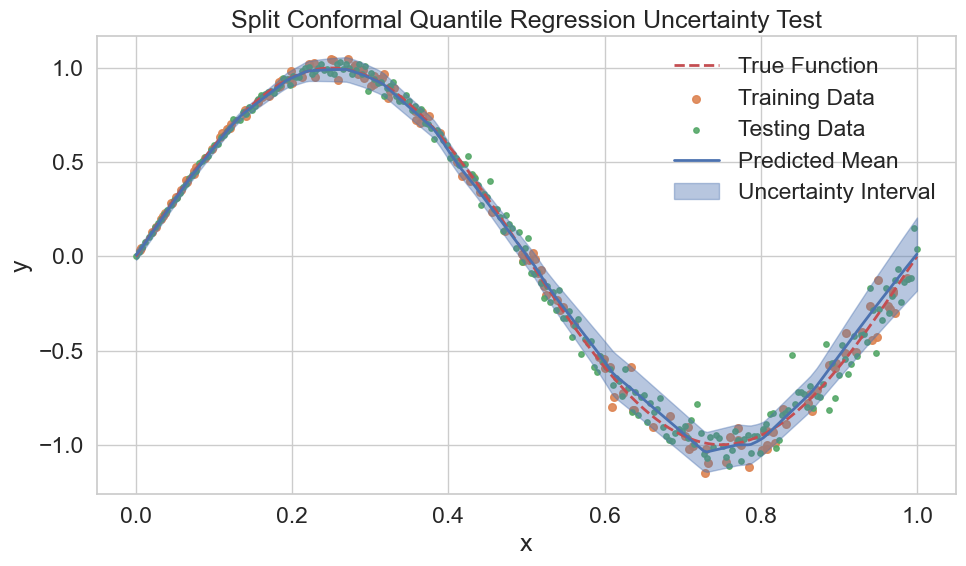

In [12]:
plot_uncertainty_results(*cqr_sol, "Split Conformal Quantile Regression")

### K-fold Conformal Quantile Regression 

In [ ]:
from uqregressors.conformal.k_fold_cqr import KFoldCQR
    
k_fold_cqr = KFoldCQR(
    n_estimators=5, # Number of models in the ensemble
    hidden_sizes=[100, 100],
    alpha=0.1, 
    tau_lo=0.05, # Lower quantile the underlying regressor is trained for; can be tuned
    dropout=None,
    epochs=2500,
    learning_rate=1e-3,
    device="cpu",
    n_jobs=1, # Experimental: number of parallel processes using joblib
    use_wandb=False)

k_fold_cqr.fit(X_train, y_train)
k_fold_cqr_sol = k_fold_cqr.predict(X_test)

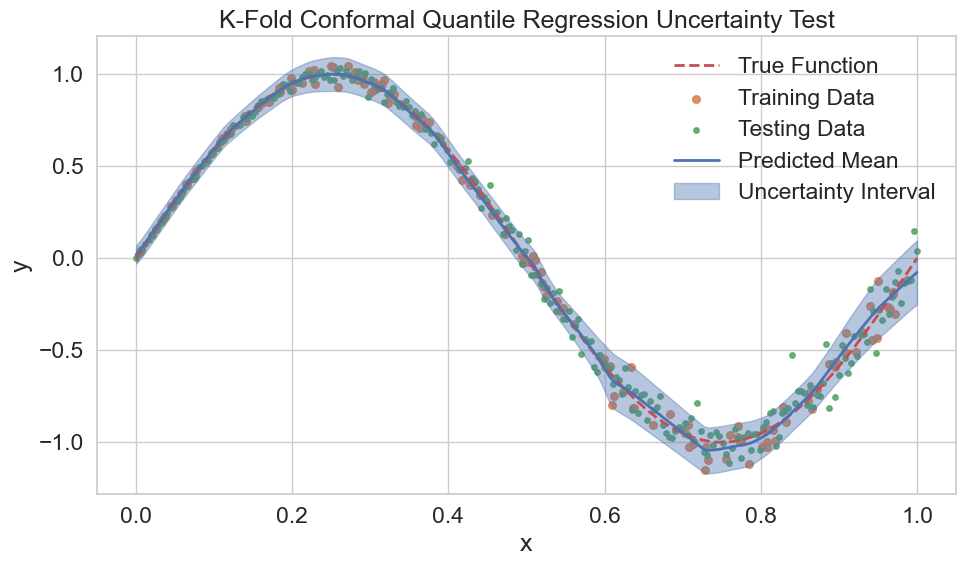

In [13]:
plot_uncertainty_results(*k_fold_cqr_sol, "K-Fold Conformal Quantile Regression")

### Normalized ConformalEns

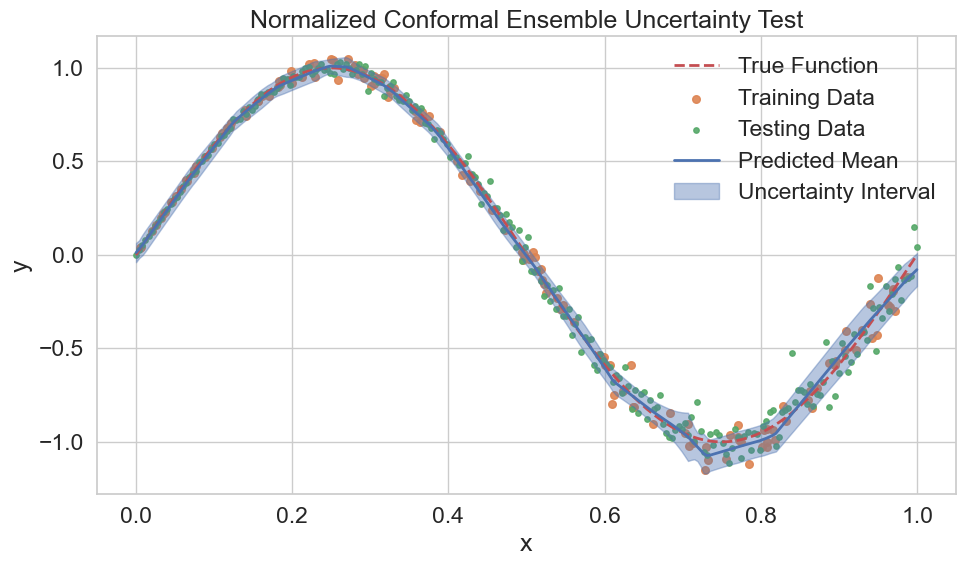

In [ ]:
from uqregressors.conformal.conformal_ens import ConformalEnsRegressor

conformal_ens = ConformalEnsRegressor(
    n_estimators=5, 
    hidden_sizes=[100, 100],
    alpha=0.1,
    cal_size=0.2,
    epochs=1000,
    gamma=0, # Normalization constant added for stability; can be tuned
    dropout=None,
    learning_rate=1e-3,
    device="cpu",
    n_jobs=1,
    use_wandb=False)

conformal_ens.fit(X_train, y_train)
conformal_ens_sol = conformal_ens.predict(X_test)

plot_uncertainty_results(*conformal_ens_sol, "Normalized Conformal Ensemble")

## Metrics

Several metrics can be calculated from the predicted and true values on the test set. If just computing metrics for one model, see the previous example script for usage of the method: `compute_all_metrics`. Otherwise, to graphically compare the metrics of several models, use the method `plot_metrics_comparisons`. For details on each of the metrics, see the metrics example. 

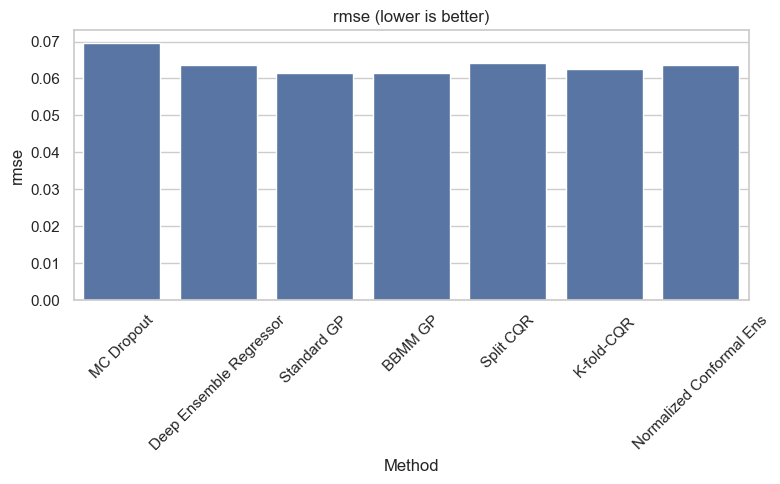

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\rmse_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\rmse_metrics_test.png


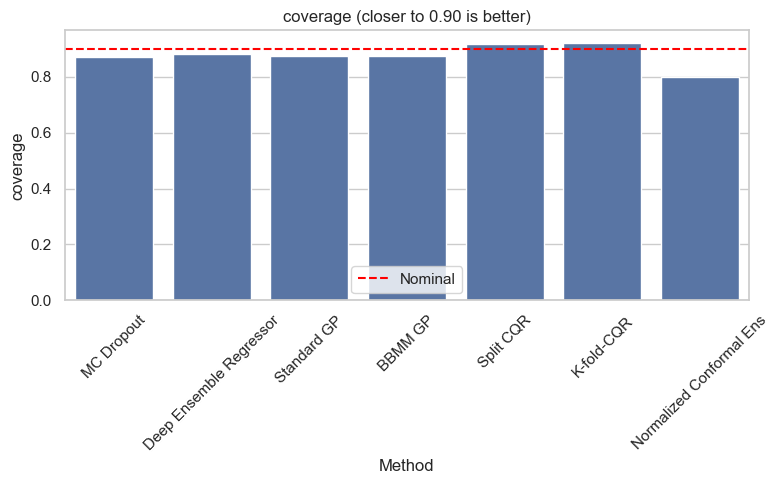

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\coverage_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\coverage_metrics_test.png


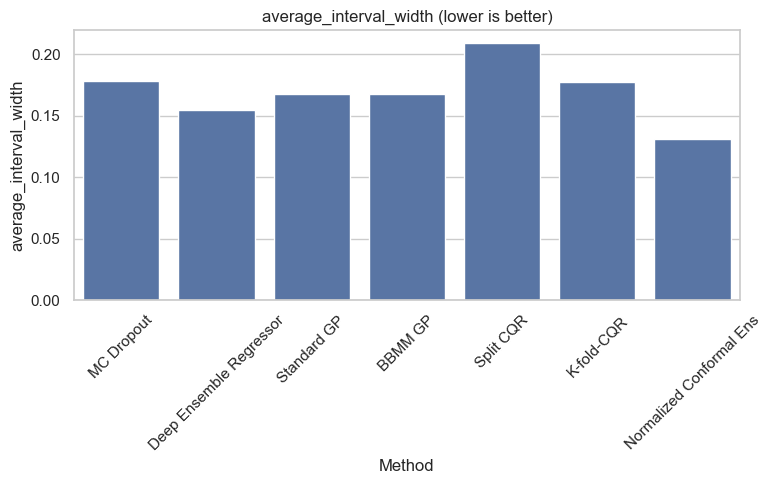

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\average_interval_width_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\average_interval_width_metrics_test.png


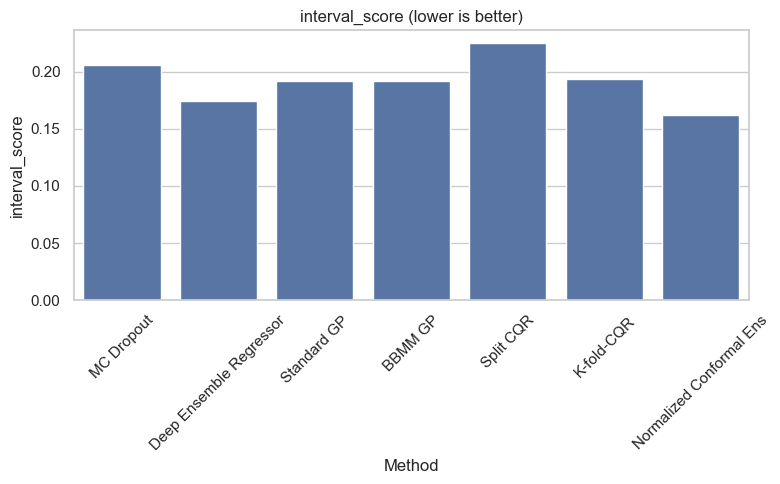

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\interval_score_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\interval_score_metrics_test.png


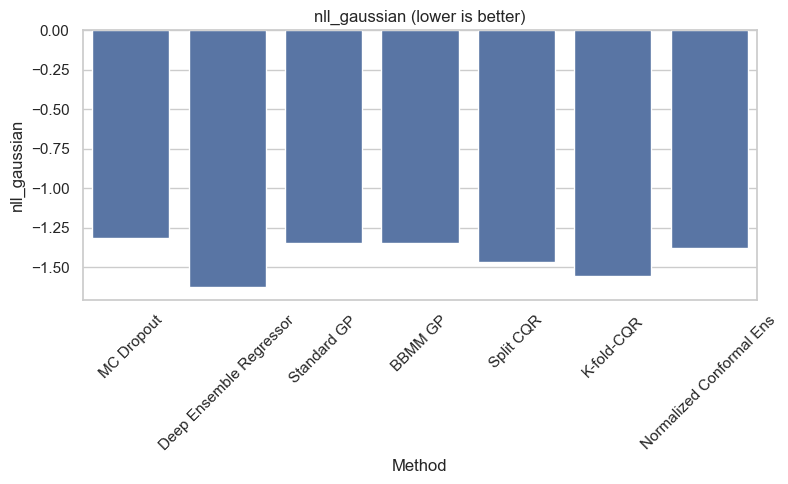

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\nll_gaussian_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\nll_gaussian_metrics_test.png


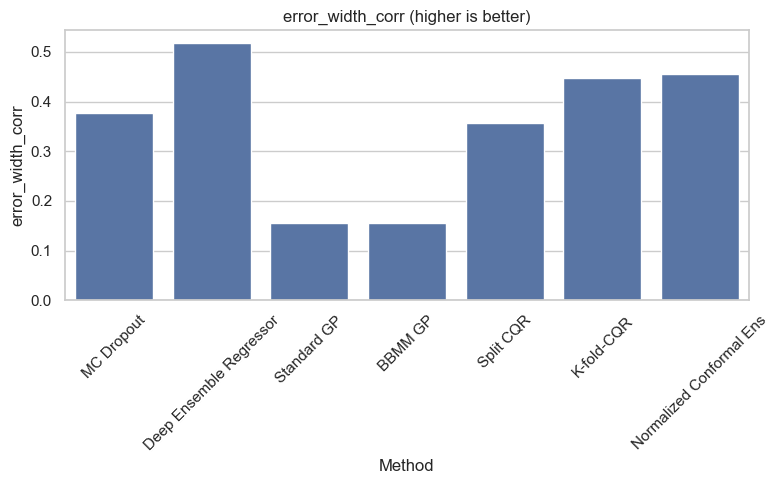

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\error_width_corr_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\error_width_corr_metrics_test.png


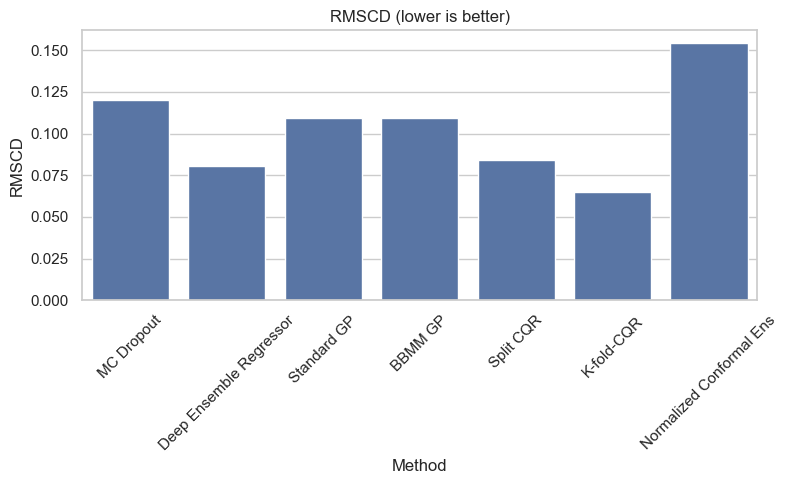

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\RMSCD_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\RMSCD_metrics_test.png


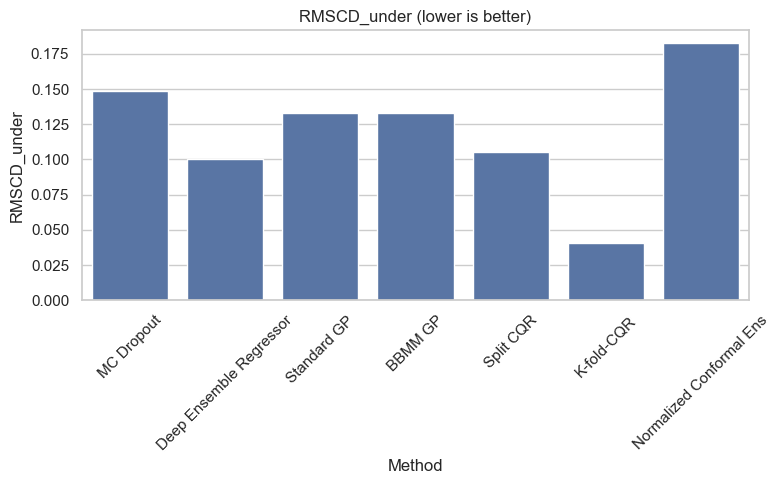

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\RMSCD_under_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\RMSCD_under_metrics_test.png


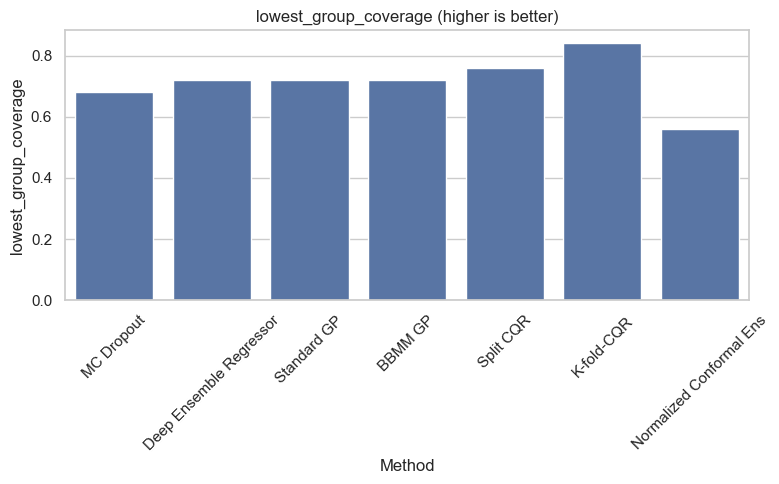

Plot saved to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\lowest_group_coverage_metrics_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\metrics_curve_tests\plots\lowest_group_coverage_metrics_test.png


WindowsPath('C:/Users/arsha/.uqregressors/metrics_curve_tests')

In [57]:
from uqregressors.utils.file_manager import FileManager
from uqregressors.plotting.plotting import plot_metrics_comparisons
from pathlib import Path

sns.set(style="whitegrid", font_scale=1)

sol_dict = {"MC Dropout": dropout_sol, 
            "Deep Ensemble Regressor": deep_ens_sol, 
            "Standard GP": gp_sol, 
            "BBMM GP": bbmm_gp_sol, 
            "Split CQR": cqr_sol, 
            "K-fold-CQR": k_fold_cqr_sol, 
            "Normalized Conformal Ens": conformal_ens_sol
            }

plot_metrics_comparisons(sol_dict, 
                         y_test, 
                         alpha=0.1, 
                         show=True, 
                         save_dir=Path.home()/".uqregressors"/"metrics_curve_tests", 
                         log_metrics=[], # Which metrics to display on a log scale
                         filename="metrics_test.png")

## Visualization
### Calibration Curves
Generates a calibration curve for the model. This sweeps the predictions through a range of confidence levels and evaluates how close the coverage given by the predicted intervals is to the desired confidence level. The two methods useful here are `generate_cal_curve`, which outputs the data needed for plotting the calibration curve, and `plot_cal_curve`, which plots the calibration curve. 

Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmp_zma25_5\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpkntl7um3\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmp8w3s_uc5\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpjix8a44u\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpad5mm5tn\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpr79nkajn\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmpxwxo8guq\models\MCDropoutRegressor_20250703_150234
Model and additional artifacts saved to: C:\Users\arsha\AppData\Local\Temp\tmp0y07es5r\models\MCD

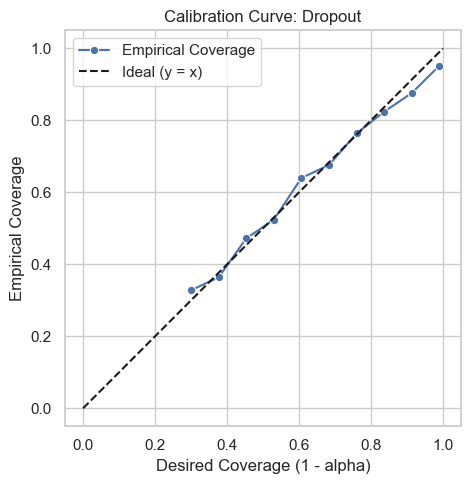

Plot saved to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\dropout_test.png
Saved calibration curve to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\dropout_test.png


WindowsPath('C:/Users/arsha/.uqregressors/calibration_curve_tests/plots/dropout_test.png')

In [58]:
from uqregressors.plotting.plotting import generate_cal_curve, plot_cal_curve
from pathlib import Path

"""
Generate data with generate_cal_curve. If true, refit will re-train the 
model for each confidence level (only necessary for quantile regressors)

Returns desired coverage, empirical coverage, and average interval width.
"""

des_cov, emp_cov, avg_width = generate_cal_curve(dropout, X_test, y_test, 
                                                 refit=False, X_train=X_train, 
                                                 y_train=y_train)


plot_cal_curve(des_cov, 
               emp_cov, 
               show=True, 
               save_dir=Path.home()/".uqregressors"/"calibration_curve_tests", 
               filename="dropout_test.png", 
               title="Calibration Curve: Dropout")

### Predicted vs. True Values
The method `plot_pred_vs_true` plots the predicted values against the true values in the test set, with the option to include the predicted confidence intervals.

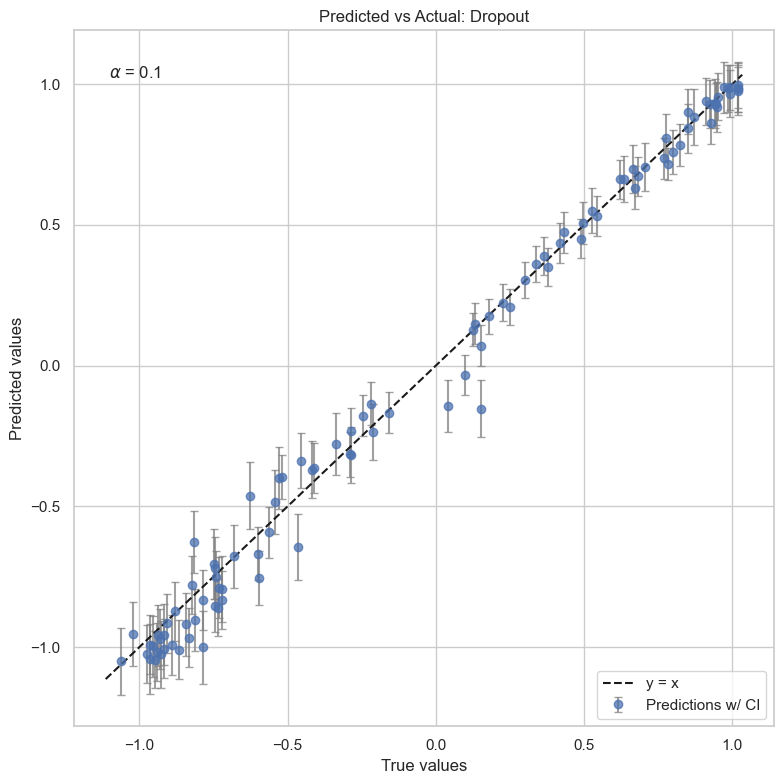

Plot saved to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\dropout_test.png
Saved calibration curve to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\dropout_test.png


WindowsPath('C:/Users/arsha/.uqregressors/calibration_curve_tests/plots/dropout_test.png')

In [ ]:
from uqregressors.plotting.plotting import plot_pred_vs_true

plot_pred_vs_true(*dropout_sol, 
                  y_test, 
                  samples=100, # Number of points randomly subsampled for plotting
                  include_confidence=True, # Whether to include the confidence interval
                  alpha=0.1, 
                  title="Predicted vs Actual: Dropout",  
                  save_dir=Path.home()/".uqregressors"/"calibration_curve_tests", 
                  filename="dropout_test.png", 
                  show=True)

## Hyperparameter Tuning
A simple example of using the `tune_hyperparams` method is used to tune the lower and upper quantiles of a split conformal quantile regressor using Bayesian Optimization. More detail on how to use the trial objects to suggest parameters for Bayesian Optimization is given in the [Optuna documentation](https://optuna.org/#code_examples). 

In [ ]:
from uqregressors.tuning.tuning import tune_hyperparams, interval_width

# Use Optuna to suggest parameters for the upper and lower quantiles of CQR
param_space = {
    "tau_lo": lambda trial: trial.suggest_float("tau_lo", 0.01, 0.1), # Parameter bounds
}

# Run hyperparameter tuning study
opt_cqr, opt_score, study = tune_hyperparams(
                                            regressor=cqr,
                                            param_space=param_space,
                                            X=X_train,
                                            y=y_train,
                                            score_fn=interval_width, # Can use custom scoring functions
                                            greater_is_better=False, # Minimize score function
                                            n_trials=5,
                                            n_splits=3, # cross validation used if n_splits > 1
                                            verbose=False,
                                            )
opt_cqr_sol = opt_cqr.predict(X_test)

# Plot predictions from the tuned method
plot_uncertainty_results(*opt_cqr_sol, "Tuned Quantile Split Conformal Quantile Regression")

# Plot metrics comparisons between the tuned and untuned models
hyperparam_comparison_dict = {"CQR_untuned": cqr_sol, 
                              "CQR_tuned": opt_cqr_sol}

For this simple example, hyperparameter tuning of the quantiles will result in slightly smaller average interval width while maintaining coverage (note that the optimization was not run to convergence, so the interval width may not actually be smaller)

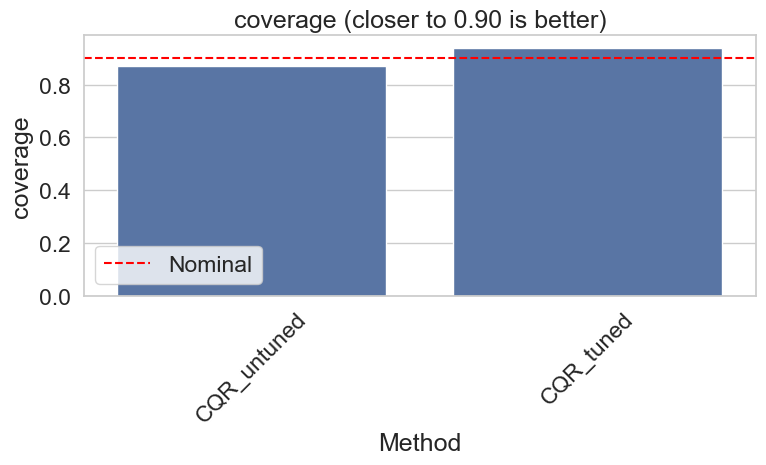

Plot saved to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\coverage_dropout_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\coverage_dropout_test.png


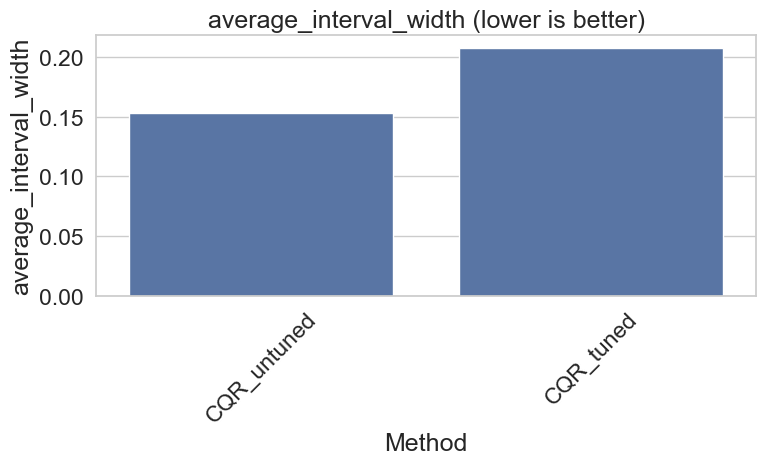

Plot saved to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\average_interval_width_dropout_test.png
Saved model comparison to C:\Users\arsha\.uqregressors\calibration_curve_tests\plots\average_interval_width_dropout_test.png


WindowsPath('C:/Users/arsha/.uqregressors/calibration_curve_tests')

In [11]:
from uqregressors.plotting.plotting import plot_metrics_comparisons
from pathlib import Path

plot_metrics_comparisons(hyperparam_comparison_dict, y_test, alpha=0.1, show=True, 
                         save_dir=Path.home()/".uqregressors"/"calibration_curve_tests", 
                         filename="dropout_test.png", log_metrics=[], 
                         excluded_metrics=["rmse", "interval_score", "nll_gaussian", 
                                           "RMSCD_under", "RMSCD", "lowest_group_coverage", 
                                           "error_width_corr"])